In [4]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import MySQLdb
from sklearn.preprocessing import LabelEncoder
from sqlalchemy import create_engine
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()
matplotlib.style.use('ggplot')

In [1]:
"""
SQL QUERY:
SELECT UniqueKey, CreatedDate, ClosedDate, Agency, ComplaintType,Descriptor, IncidentZip, City, Borough
FROM Data 
WHERE 
(IncidentZip LIKE '1%') AND
(STR_TO_DATE(LEFT(CreatedDate,LOCATE(' ',CreatedDate)),'%m/%d/%Y') BETWEEN '2015-01-01' AND '2016-01-21')
ORDER BY 
RAND() 
;

**would not execute in Jupyter Notebook.  Exported as CSV and imported below.


"""

"\nSQL QUERY:\nSELECT UniqueKey, CreatedDate, ClosedDate, Agency, ComplaintType,Descriptor, IncidentZip, City, Borough\nFROM Data \nWHERE \n(IncidentZip LIKE '1%') AND\n(STR_TO_DATE(LEFT(CreatedDate,LOCATE(' ',CreatedDate)),'%m/%d/%Y') BETWEEN '2015-01-01' AND '2016-01-21')\nORDER BY \nRAND() \n;\n\n**would not execute in Jupyter Notebook.  Exported as CSV and imported below.\n\n\n"

In [5]:
df=pd.read_csv('2015_data_1_31.csv', low_memory=False)

In [11]:
"""
1.  Need to convert CreatedDate & ClosedDate to datetime format
"""
df['CreatedDate'] = pd.to_datetime(df['CreatedDate'])
df['ClosedDate'] = pd.to_datetime(df['ClosedDate'])

#Create New column calculating length of resolving each complaint
df['Length'] = df['ClosedDate'] - df['CreatedDate']

#Drop rows where complaint has not yet been completed.
df = df[df['Length'].notnull()]


#creating new features to more easily slice data.
df['dayofweek'] = df['CreatedDate'].dt.dayofweek
df['hour'] = df['CreatedDate'].dt.hour
df['month'] = df['CreatedDate'].dt.month
df['year']= df['CreatedDate'].dt.year
df['dayofmonth']= df['CreatedDate'].dt.day
df['days'] = pd.to_datetime(df['Length']).dt.day

In [12]:
df.head()

UniqueKey         CreatedDate          ClosedDate Agency  \
0   29612667 2015-01-01 01:00:16 2015-01-01 02:03:52   NYPD   
1   29613137 2015-01-01 01:00:33 2015-01-01 02:23:58   NYPD   
2   29616860 2015-01-01 13:01:00 2015-01-01 17:20:00    DOT   
3   29617297 2015-01-01 13:01:05 2015-01-06 14:19:13    DOT   
4   29610588 2015-01-01 01:01:10 2015-01-01 16:21:05   NYPD   

              ComplaintType              Descriptor IncidentZip  \
0          Blocked Driveway               No Access       11233   
1        Noise - Commercial        Loud Music/Party       11366   
2  Traffic Signal Condition         Veh Signal Lamp       11235   
3          Street Condition  Blocked - Construction       11211   
4          Blocked Driveway               No Access       10465   

            City   Borough          Length  dayofweek  hour  month  year  \
0       BROOKLYN  BROOKLYN 0 days 01:03:36          3     1      1  2015   
1  FRESH MEADOWS    QUEENS 0 days 01:23:25          3     1      1  2015   
2       BROOKLYN  BROOKLYN 0 days 04:19:00          3    13      1  2015   
3       BROOKLYN  BROOKLYN 5 days 01:18:08          3    13      1  2015   
4          BRONX     BRONX 0 days 15:19:55          3     1      1  2015   

   dayofmonth  days  
0           1     1  
1           1     1  
2           1     1  
3           1     6  
4           1     1

In [38]:
df.describe()

UniqueKey                    Length     dayofweek          hour  \
count  1.897202e+06                   1897202  1.897202e+06  1.897202e+06   
mean   3.096204e+07   10 days 14:23:49.145242  2.811706e+00  1.099991e+01   
std    7.868873e+05  248 days 08:31:07.559237  1.961491e+00  7.355575e+00   
min    2.651366e+07     -42358 days +23:24:40  0.000000e+00  0.000000e+00   
25%    3.027291e+07           0 days 03:07:34  1.000000e+00  5.000000e+00   
50%    3.096605e+07           1 days 21:05:37  3.000000e+00  1.200000e+01   
75%    3.164990e+07           8 days 00:00:00  4.000000e+00  1.700000e+01   
max    3.398344e+07        1533 days 11:51:37  6.000000e+00  2.300000e+01   

              month          year    dayofmonth          days  
count  1.897202e+06  1.897202e+06  1.897202e+06  1.897202e+06  
mean   6.414459e+00  2.015002e+03  1.564752e+01  5.868303e+00  
std    3.460521e+00  4.573677e-02  8.766875e+00  7.141055e+00  
min    1.000000e+00  2.015000e+03  1.000000e+00  1.000000e+00  
25%    3.000000e+00  2.015000e+03  8.000000e+00  1.000000e+00  
50%    6.000000e+00  2.015000e+03  1.600000e+01  2.000000e+00  
75%    9.000000e+00  2.015000e+03  2.300000e+01  8.000000e+00  
max    1.200000e+01  2.016000e+03  3.100000e+01  3.100000e+01

In [65]:
df[df['ClosedDate']=='']

Empty DataFrame
Columns: [UniqueKey, CreatedDate, ClosedDate, Agency, ComplaintType, Descriptor, IncidentZip, City, Borough, Length, dayofweek, hour, month, year, dayofmonth, days]
Index: []

Note we are using 2015 data, thus we have no CreatedDate cells with null values

In [73]:
#slice data to only include entries in Brooklyn
#this excludes values that are not specificed to a specific Borough.
#note that in previous analysis we found there were some 311 calls that request 
#finance literature that specifically do not input their location
#for sake of this analysis we will assume distributing literature is not under 
#complaint category we are interested in.
df = df[df['Borough']=='BROOKLYN']

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597309 entries, 0 to 1947197
Data columns (total 16 columns):
UniqueKey        597309 non-null int64
CreatedDate      597309 non-null datetime64[ns]
ClosedDate       597309 non-null datetime64[ns]
Agency           597309 non-null object
ComplaintType    597309 non-null object
Descriptor       593141 non-null object
IncidentZip      597309 non-null object
City             597309 non-null object
Borough          597309 non-null object
Length           597309 non-null timedelta64[ns]
dayofweek        597309 non-null int64
hour             597309 non-null int64
month            597309 non-null int64
year             597309 non-null int64
dayofmonth       597309 non-null int64
days             597309 non-null int64
dtypes: datetime64[ns](2), int64(7), object(6), timedelta64[ns](1)
memory usage: 77.5+ MB


In [6]:

# df.to_csv('2015-data-dataframe-2-1')

In [77]:
# ------------------------
#merge heat/hot water and heating calls to one complainttype
#similar season trend here, want to be able to look at other variables as well, but don't want to drop
#values as these are important to have in our data set
# df['ComplaintType'].replace(to_replace = 'HEAT/HOT WATER', value ='HEATING',inplace=True)

# ------------------------

backup = df

In [79]:
#resetting index
df = df.reset_index()
del df['index']

In [80]:
df.head()

UniqueKey         CreatedDate          ClosedDate Agency  \
0   29612667 2015-01-01 01:00:16 2015-01-01 02:03:52   NYPD   
1   29616860 2015-01-01 13:01:00 2015-01-01 17:20:00    DOT   
2   29617297 2015-01-01 13:01:05 2015-01-06 14:19:13    DOT   
3   29611033 2015-01-01 01:01:12 2015-01-01 01:31:45   NYPD   
4   29613296 2015-01-01 01:03:57 2015-01-01 05:08:01   NYPD   

              ComplaintType              Descriptor IncidentZip      City  \
0          Blocked Driveway               No Access       11233  BROOKLYN   
1  Traffic Signal Condition         Veh Signal Lamp       11235  BROOKLYN   
2          Street Condition  Blocked - Construction       11211  BROOKLYN   
3          Blocked Driveway               No Access       11236  BROOKLYN   
4        Noise - Commercial        Loud Music/Party       11238  BROOKLYN   

    Borough          Length  dayofweek  hour  month  year  dayofmonth  days  
0  BROOKLYN 0 days 01:03:36          3     1      1  2015           1     1  
1  BROOKLYN 0 days 04:19:00          3    13      1  2015           1     1  
2  BROOKLYN 5 days 01:18:08          3    13      1  2015           1     6  
3  BROOKLYN 0 days 00:30:33          3     1      1  2015           1     1  
4  BROOKLYN 0 days 04:04:04          3     1      1  2015           1     1

In [43]:
#Exploring the Data

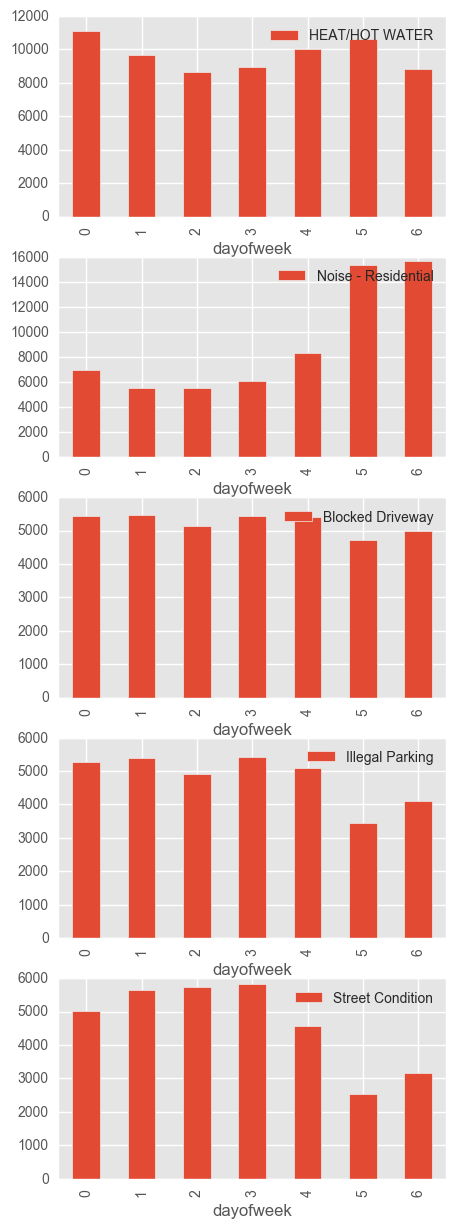

In [81]:
# The day of the week with Monday=0, Sunday=6
#volume of calls by day, for top n ComplaintTypes for all of NYC
n = 5
complaints = df['ComplaintType'].value_counts().head(n).index.tolist()
fig, ax = plt.subplots(n,1,figsize=(5,15))
for x,ax in zip(complaints,ax):
    df[df['ComplaintType']==x].groupby('dayofweek').count()['UniqueKey'].plot(kind='bar',ax=ax, label = x)
    ax.legend()

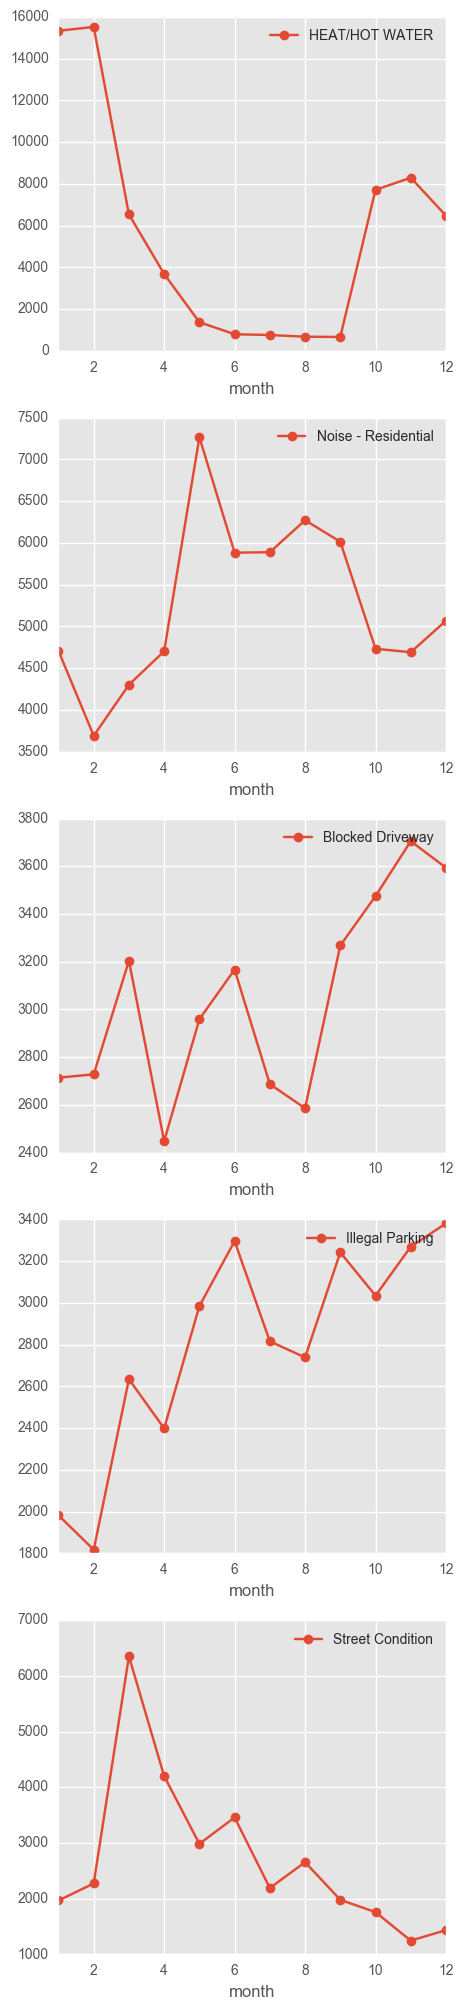

In [82]:
#number of calls monthly, for top n ComplaintTypes for all of NYC
n = 5
complaints = df['ComplaintType'].value_counts().head(n).index.tolist()
fig, ax = plt.subplots(n,1,figsize=(5,25))
for x,ax in zip(complaints,ax):
    df[df['ComplaintType']==x].groupby('month').count()['UniqueKey'].plot(ax=ax, label = x, style ='-o')
    ax.legend()
plt.savefig('Trends.jpg')

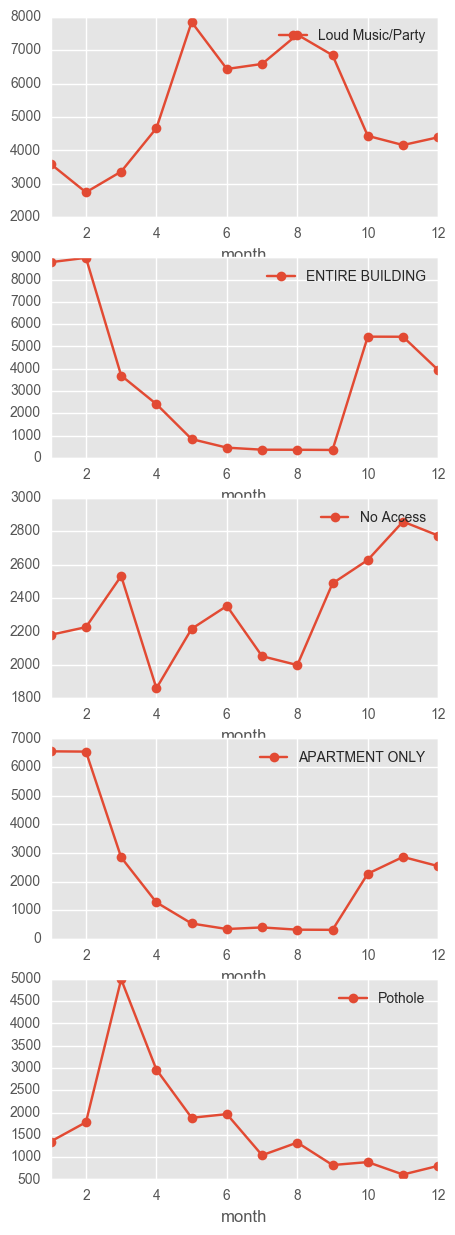

In [83]:
#number of calls monthly, for top n descriptors for all of NYC
n = 5
descriptors = df['Descriptor'].value_counts().head(n).index.tolist()
fig, ax = plt.subplots(n,1,figsize=(5,15))
for x,ax in zip(descriptors,ax):
    df[df['Descriptor']==x].groupby('month').count()['UniqueKey'].plot(ax=ax, label = x, style ='-o')
    ax.legend()

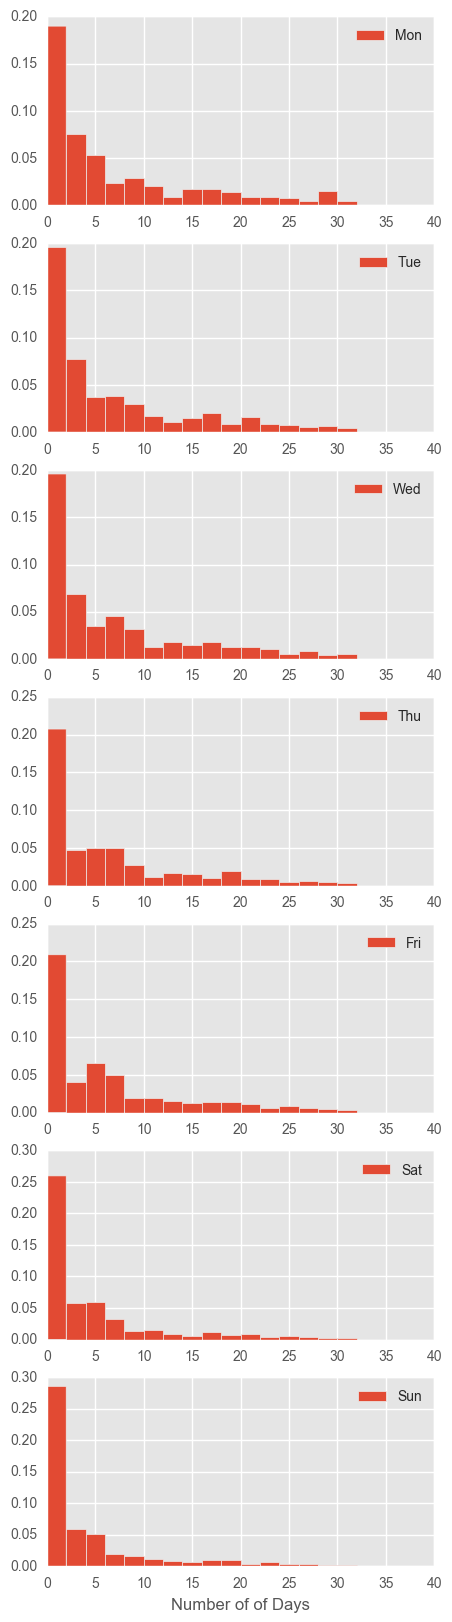

In [84]:
# Histogram showing distribution of time to resolve calls
bins = range(0,40,2)
days = range(0,7)
weekday = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
fig, ax = plt.subplots(7,1,figsize=(5,20))
for day, ax, wd in zip(days, ax, weekday):
              df[df["dayofweek"]==day]["days"].hist(bins=bins,ax=ax, normed=True, label=wd)
              ax.legend()
              plt.xlabel('Number of of Days')

There is some variance based on Day of Week call was placed.
Calls made later on in the week tend to take longer to be resolved.
This will be an important feature in the modeling step.

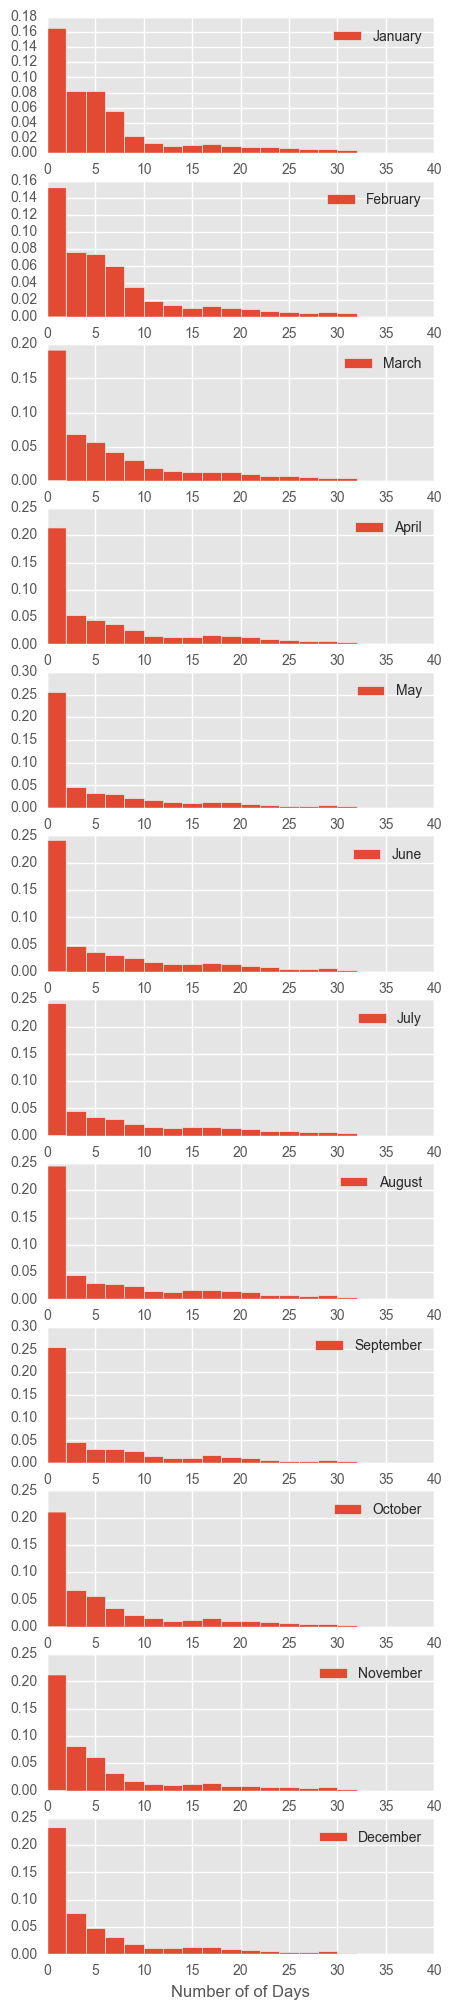

In [85]:
# Histogram showing distribution of time to resolve calls by month
bins = range(0,40,2)
months = range(1,13)
monthlabel = ['January','February','March','April','May','June','July','August','September','October','November','December']
fig, ax = plt.subplots(12,1,figsize=(5,25))
for month, ax, ml in zip(months, ax, monthlabel):
              df[df["month"]==month]["days"].hist(bins=bins,ax=ax, normed=True, label=ml)
              ax.legend()
              plt.xlabel('Number of of Days')

Response time seems to spike in January then tapers off April, progressively decreaes until an icnrease in October.  Month will be an important feature in our model

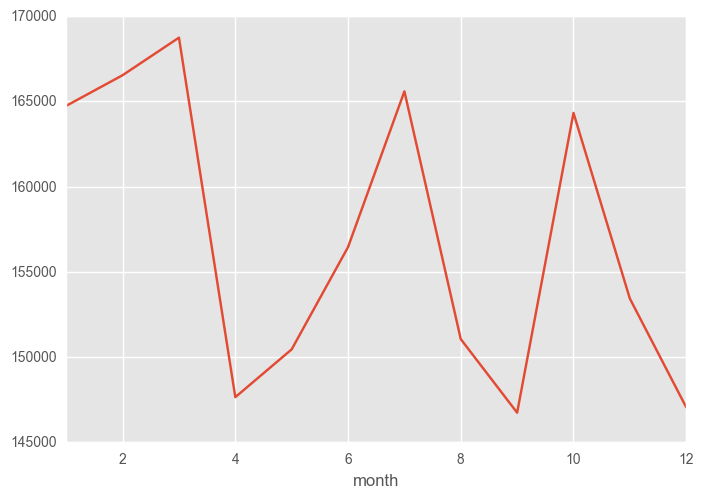

In [37]:
df.groupby('month')['Descriptor'].count().plot()

This chart shows the number of calls placed monthly across all different complaint types.
It's interesting to not that volume seems to drop substantially at the end of each season.

In [54]:
df.groupby('month')['ComplaintType'].describe()

month        
1      count                  165513
       unique                    156
       top            HEAT/HOT WATER
       freq                    49946
2      count                  167230
       unique                    158
       top            HEAT/HOT WATER
       freq                    49278
3      count                  169674
       unique                    157
       top          Street Condition
       freq                    23201
4      count                  148817
       unique                    160
       top       Noise - Residential
       freq                    16082
5      count                  151752
       unique                    158
       top       Noise - Residential
       freq                    22555
6      count                  157806
       unique                    159
       top       Noise - Residential
       freq                    18411
7      count                  167222
       unique                    163
       top       Noise -

**Above shows top complaint types by month.**

-Predictably, HEAT/HOT WATER complaints are predominant in the cold months.  
-Spring and Summer months are largely dominated by noise complaints

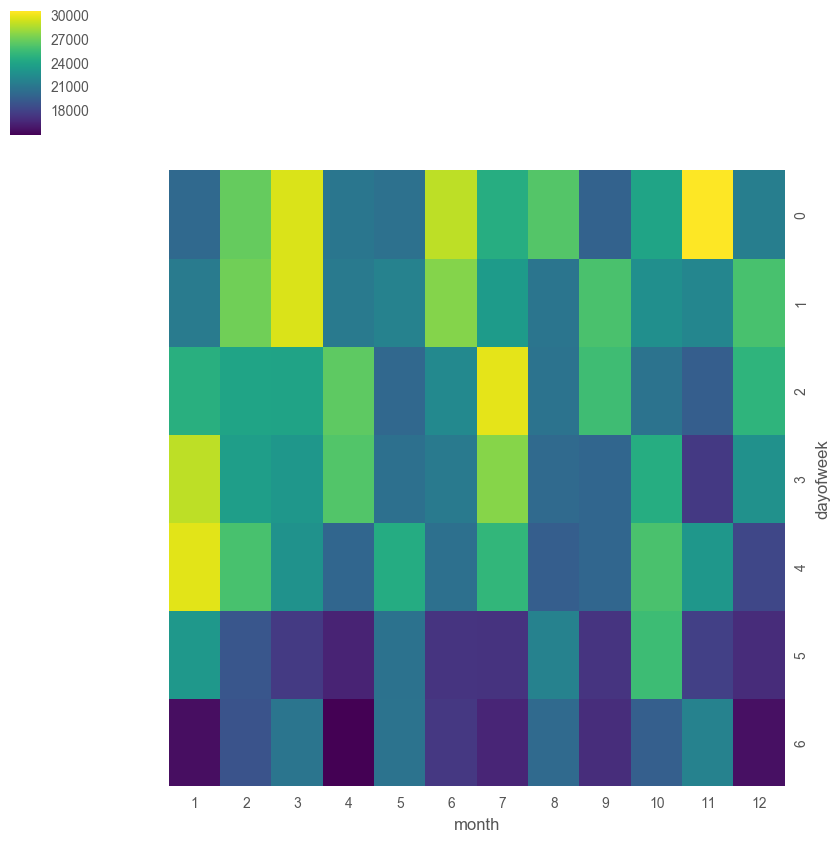

In [21]:
dayMonth = df.groupby(by=['dayofweek', 'month']).count()['Descriptor'].unstack()
sns.clustermap(dayMonth,cmap='viridis', row_cluster = False, col_cluster=False)
# The day of the week with Monday=0, Sunday=6

- This heatmap shows count of Complaints by Complaint Type and Month for the top 20 most common complaints.

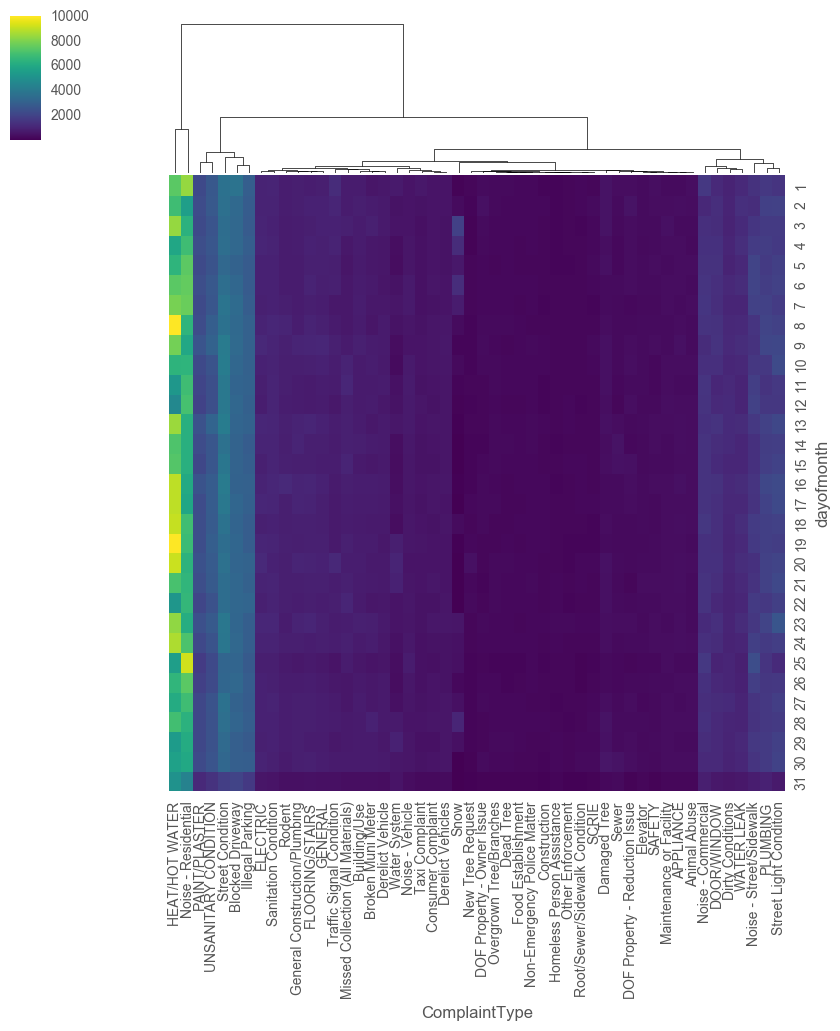

In [35]:
"""
1.  Creates Heatmap of top n complaints (edit n= below to adjust this)
2.  Need to see if I can adjust order of months / measures as they are not chronological
"""

n=50
topcomplaints = df['ComplaintType'].value_counts().head(n).index.tolist()

df3=[]
df3 = df[df['ComplaintType'].isin(topcomplaints)]

ComplaintMonth = df3.groupby(by=['dayofmonth','ComplaintType']).count()['Descriptor'].unstack()
ComplaintMonth.fillna(0, inplace=True)
sns.clustermap(ComplaintMonth,cmap='viridis', row_cluster=False)

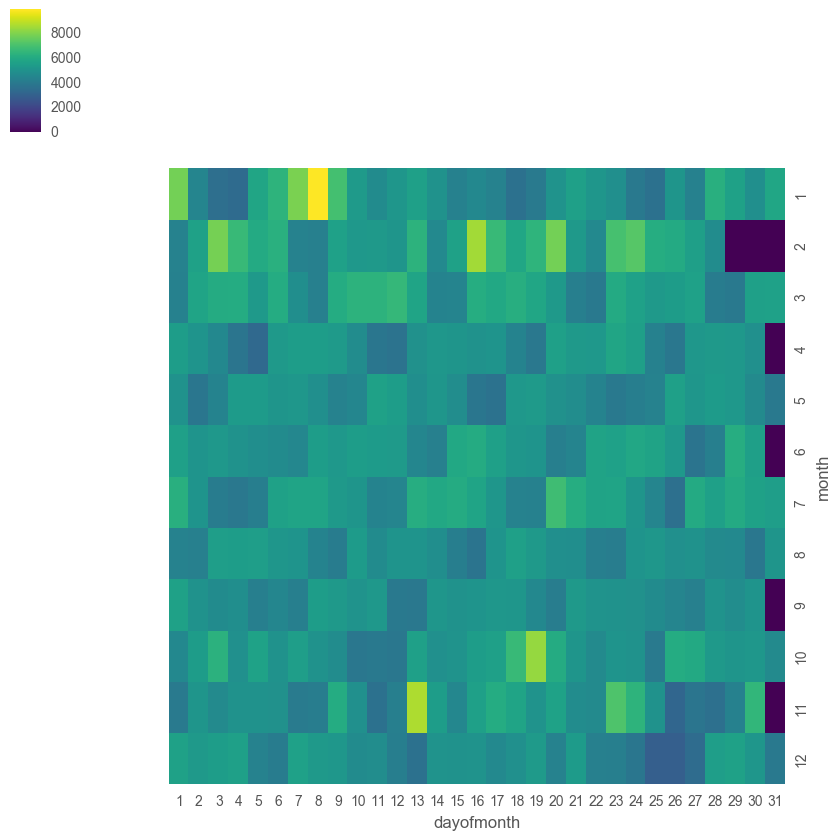

In [33]:
"""
1.  Heatmap shows total complaints in data set by month and day of month
"""

ComplaintMonth = df.groupby(by=['month','dayofmonth']).count()['Descriptor'].unstack()
ComplaintMonth.fillna(0, inplace=True)
sns.clustermap(ComplaintMonth,cmap='viridis', row_cluster=False, col_cluster=False)

- Plotting a histogram for every day of the month would be too difficult, employing a heatmap to get a zoomed out perspective of data.
- Although not important for all complainttpes there is substantial variance in count of calls by day of month in the first graphic.

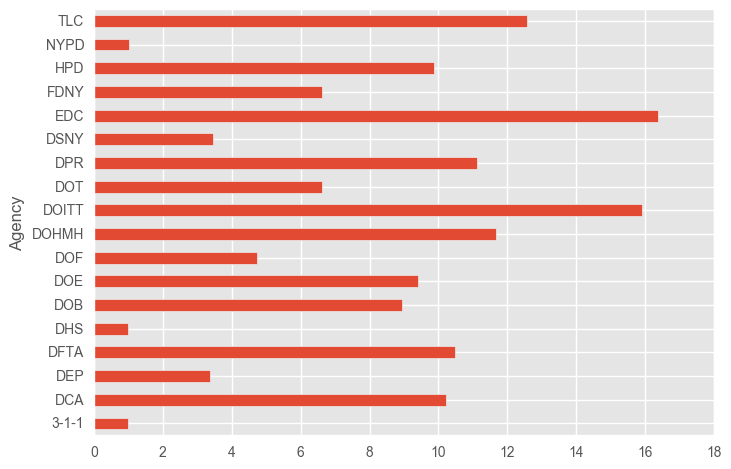

In [93]:
df.groupby('Agency')['days'].mean().plot(kind='barh')

In [92]:
df[df['Agency']=='DOITT']
#payphone complaints not relevant

UniqueKey         CreatedDate          ClosedDate Agency  \
6513     29635452 2015-01-05 08:33:33 2015-01-22 11:26:29  DOITT   
7938     29643203 2015-01-06 14:05:09 2015-01-22 11:26:23  DOITT   
10432    29653842 2015-01-07 10:30:38 2015-02-11 15:25:14  DOITT   
19942    29691903 2015-01-11 16:28:11 2015-01-13 15:39:51  DOITT   
28087    29727803 2015-01-16 16:43:07 2015-02-19 13:51:07  DOITT   
33427    29751482 2015-01-20 14:47:57 2015-02-05 09:12:33  DOITT   
33873    29757314 2015-01-20 21:53:51 2015-02-05 09:19:08  DOITT   
35363    29762171 2015-01-21 18:43:13 2015-02-05 09:21:16  DOITT   
40406    29786950 2015-01-24 18:35:42 2015-02-19 13:52:10  DOITT   
48004    29817689 2015-01-29 17:47:16 2015-02-25 09:49:50  DOITT   
68015    29902578 2015-02-09 16:19:01 2015-02-25 09:50:54  DOITT   
69876    29908831 2015-02-10 18:06:34 2015-02-25 09:52:02  DOITT   
80182    29964077 2015-02-16 16:22:25 2015-03-26 09:09:56  DOITT   
106911   30069497 2015-03-01 06:40:59 2015-03-02 10:26:16  DOITT   
106918   30070376 2015-03-01 06:46:02 2015-03-18 10:48:49  DOITT   
127559   30163775 2015-03-12 11:55:34 2015-04-08 09:31:20  DOITT   
153364   30275443 2015-03-27 12:58:19 2015-05-05 15:58:18  DOITT   
156016   30290020 2015-03-30 14:23:00 2015-04-27 09:12:37  DOITT   
158586   30302862 2015-03-31 22:46:38 2015-05-05 16:01:30  DOITT   
158591   30301652 2015-03-31 22:49:42 2015-05-05 16:04:57  DOITT   
160251   30314067 2015-04-01 10:17:50 2015-05-05 16:06:03  DOITT   
165713   30336956 2015-04-05 11:25:50 2015-05-05 17:39:37  DOITT   
166884   30341449 2015-04-06 10:22:59 2015-04-27 09:13:45  DOITT   
189981   30448753 2015-04-21 10:23:05 2015-05-07 10:05:19  DOITT   
200742   30504503 2015-04-28 18:31:24 2015-05-13 10:04:23  DOITT   
205804   30527967 2015-05-01 07:41:27 2015-05-19 15:30:35  DOITT   
233889   30657589 2015-05-19 17:59:11 2015-06-25 09:16:38  DOITT   
243941   30702619 2015-05-26 15:50:19 2015-06-10 09:48:20  DOITT   
247422   30718723 2015-05-28 17:26:11 2015-06-10 09:51:43  DOITT   
247967   30715357 2015-05-28 09:42:00 2015-06-10 09:50:33  DOITT   
...           ...                 ...                 ...    ...   
354512   31197670 2015-07-30 11:39:11 2015-08-12 10:47:21  DOITT   
355552   31211359 2015-07-31 20:04:02 2015-08-19 11:47:55  DOITT   
356583   31204989 2015-07-31 12:52:41 2015-08-19 11:48:02  DOITT   
357415   31215219 2015-08-01 09:37:14 2015-08-19 11:50:15  DOITT   
358473   31222230 2015-08-02 16:59:13 2015-08-19 11:49:08  DOITT   
363001   31248265 2015-08-05 13:15:39 2015-09-02 09:22:53  DOITT   
364348   31242873 2015-08-05 11:03:58 2015-09-02 09:25:12  DOITT   
365348   31256004 2015-08-06 18:34:36 2015-09-02 09:26:24  DOITT   
368904   31269756 2015-08-08 10:34:10 2015-09-02 09:30:50  DOITT   
370257   31274320 2015-08-09 10:23:15 2015-09-10 15:15:35  DOITT   
370277   31274255 2015-08-09 10:34:04 2015-09-02 09:21:50  DOITT   
372062   31282451 2015-08-10 11:40:04 2015-09-02 09:24:01  DOITT   
374391   31300121 2015-08-12 19:22:17 2015-09-02 09:24:08  DOITT   
375370   31305657 2015-08-13 14:01:01 2015-09-02 09:25:14  DOITT   
377542   31314394 2015-08-14 19:06:01 2015-09-02 09:29:41  DOITT   
378082   31308984 2015-08-14 11:04:37 2015-09-02 09:26:21  DOITT   
385090   31345851 2015-08-19 08:38:42 2015-09-10 09:14:29  DOITT   
431821   31561030 2015-09-18 10:23:01 2015-10-27 13:38:08  DOITT   
443806   31621645 2015-09-26 17:57:41 2015-10-07 09:50:33  DOITT   
445555   31626222 2015-09-27 08:59:29 2015-10-07 09:51:41  DOITT   
476797   31774502 2015-10-17 17:56:09 2015-10-27 13:58:42  DOITT   
476807   31776571 2015-10-17 18:02:02 2015-11-09 10:49:10  DOITT   
506882   31906304 2015-11-03 10:15:03 2015-12-08 16:33:24  DOITT   
518565   31959136 2015-11-11 16:39:07 2015-11-30 09:11:03  DOITT   
520425   31966768 2015-11-12 10:05:33 2015-11-30 09:07:43  DOITT   
520539   31965884 2015-11-12 10:34:58 2015-12-14 11:45:02  DOITT   
532766   32026520 2015-11-19 16:47:24 2015-12-09 08:51:22  DOITT

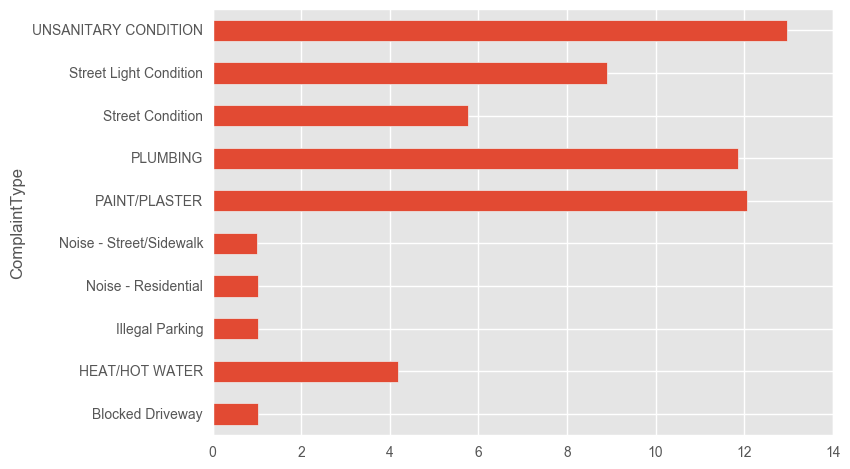

In [11]:
#mean number of days for call to be resolved for top n complaint types.
n = 10
top_complaints = df['ComplaintType'].value_counts().head(n).index.tolist()
complaints_df = df[df['ComplaintType'].isin(top_complaints)]
complaints_df.groupby('ComplaintType')['days'].mean().plot(kind='barh')

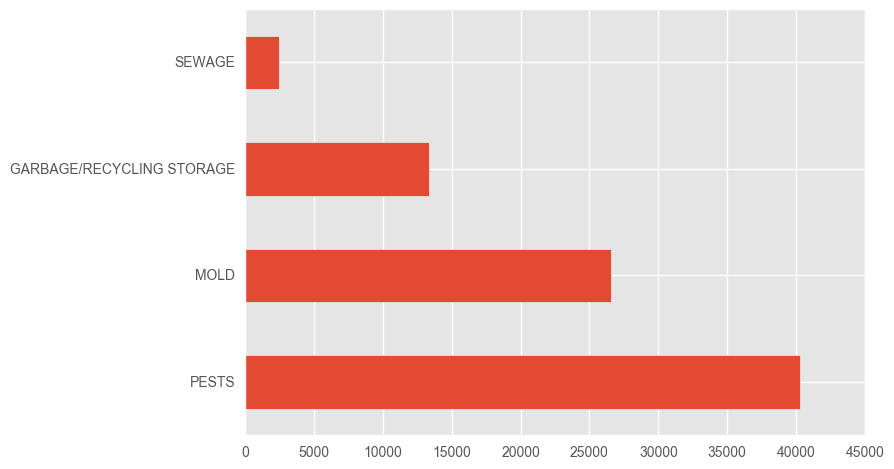

In [12]:
#spread of Descriptors in UNSANITARY CONDITIONS.
df[df['ComplaintType']=='UNSANITARY CONDITION']['Descriptor'].value_counts().plot(kind='barh')